In [55]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: Keras', keras.__version__)
np.random.seed(222)

Notebook running: Keras 2.3.1


In [1]:
import numpy as np

In [2]:
import keras

Using TensorFlow backend.


In [14]:
from keras.applications.imagenet_utils import decode_predictions

In [3]:
import skimage.io 

In [4]:
import skimage.segmentation

In [5]:
import copy

In [7]:
import sklearn

In [8]:
import sklearn.metrics

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
import warnings

In [11]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


96116736/96112376 [==============================] - 36s 0us/step


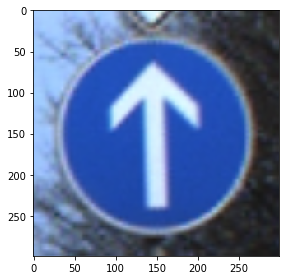

In [12]:
Xi = skimage.io.imread("correctly labeled.png")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5)

In [15]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes
print(decode_predictions(preds)[0])

40960/35363 [==================================] - 0s 1us/step
[('n06794110', 'street_sign', 0.27863985), ('n04192698', 'shield', 0.15539238), ('n02865351', 'bolo_tie', 0.14010103), ('n06874185', 'traffic_light', 0.0167503), ('n04127249', 'safety_pin', 0.010709472)]


In [16]:
top_pred_classes = preds[0].argsort()[-5:][::-1] #Returns the indices that would sort an array.
top_pred_classes                #Index of top 5 classes

array([919, 787, 451, 920, 772])

In [17]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2) #https://www.vlfeat.org/api/quickshift.html
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

67

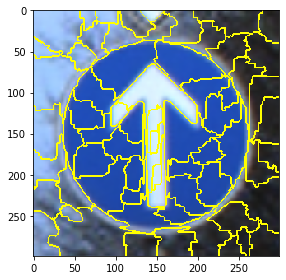

In [18]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [19]:
# For the case of images, LIME generates perturbations by turning on and off some of the super-pixels in the image. 
# The following script uses the quick-shift segmentation algorithm to compute the super-pixels in the image. (above step) 
# In addition, it generates an array of 150 perturbations where each perturbation is a vector with zeros and ones 
# that represent whether the super-pixel is on or off

#The function returns a list of samples from a binomial distribution based on the inputted parameters when calling 
#np.random.binomial(n, p, size). https://discuss.codecademy.com/t/what-does-the-np-random-binomial-function-return/361162
num_perturb = 150
perturbations = np.random.binomial (1, 0.5, size= (num_perturb, num_superpixels)) 
perturbations[0]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1])

In [20]:
# Create function to apply perturbations to images. *The* following function `perturb_image` perturbs the given image (`img`)
# based on a perturbation vector (`perturbation`) and predefined superpixels (`segments`).

def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis] # Deep copy is a process in which the copying process occurs recursively. It means first constructing a new collection object and then recursively populating it with copies of the child objects found in the original. In case of deep copy, a copy of object is copied in other object. It means that any changes made to a copy of object do not reflect in the original object. In case of shallow copy, a reference of object is copied in other object. It means that any changes made to a copy of object do reflect in the original object. 
  return perturbed_image

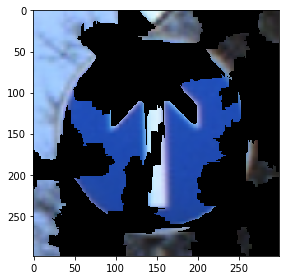

In [21]:
skimage.io.imshow(perturb_image(Xi/2+0.5, perturbations[0], superpixels))

In [22]:
# Use ML classifier to predict classes of new generated images. This is the most computationally expensive step in LIME because a 
# prediction for each perturbed image is computed. From the shape of the predictions we can see for each of the perturbations we have the output probability for each of the 1000 classes in Inception V3. 

predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

In [23]:
# Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image and we get 150 distances, 1 for each perturbation.

original_image = np.ones(num_superpixels)[np.newaxis, :] #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel() #.ravel returns contiguous flattened array
distances.shape

(150,)

In [24]:
# Use kernel function to compute weights. it return 150 weights, 1 for each perturbation 
kernel_width = 0.25 # Depeding on how we set the kernel width, it defines how wide we want the "locality" around our instance to be
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [25]:
class_to_explain = top_pred_classes[2]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.01212899, -0.00791818, -0.00471299,  0.01105576,  0.00074436,
        0.01145329, -0.00237696, -0.00198618, -0.00769894, -0.0034354 ,
       -0.0056285 , -0.0132112 , -0.00598315,  0.01020337,  0.00591   ,
       -0.00102611,  0.01097842, -0.00806492, -0.01019001,  0.00639791,
       -0.01238238,  0.00836524, -0.00042846,  0.00606436,  0.0019837 ,
        0.0002346 ,  0.00531534, -0.00799563, -0.00128604,  0.006448  ,
       -0.00099913, -0.01217151, -0.00040247, -0.00529728,  0.00752426,
       -0.00920572,  0.00680674,  0.00384043,  0.00287372,  0.00968625,
       -0.00927673, -0.01294996, -0.01088068, -0.00292288, -0.00412314,
        0.00130141, -0.00500748, -0.005183  ,  0.0100027 , -0.00393024,
       -0.00023927, -0.01618541, -0.00535708, -0.00355679,  0.00841836,
        0.0024061 ,  0.0051768 ,  0.00806788,  0.0082939 , -0.00694594,
       -0.0046818 , -0.00622427,  0.01007814,  0.00166559,  0.0047571 ,
        0.00360319, -0.01340505])

In [26]:
num_top_features = 10
top_features = np.argsort(coeff)[-num_top_features:]
top_features

array([21, 54, 39, 48, 62, 13, 16,  3,  5,  0])

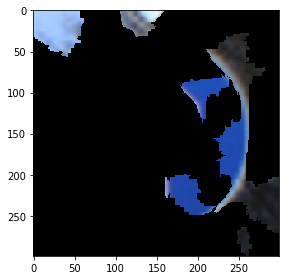

In [27]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

In [28]:
# Quantile implementation
# coeff.sort()
print(coeff)
print("\n90th quantile of arr, axis = None : ", np.quantile(coeff, 0.90))
ith_observation = 0.90 * (num_superpixels+1) # based on q (n + 1)
print(ith_observation)
num_top_features = num_superpixels-round(ith_observation)
print(num_top_features)
top_features = np.argsort(coeff)[-num_top_features:]
top_features

[ 0.01212899 -0.00791818 -0.00471299  0.01105576  0.00074436  0.01145329
 -0.00237696 -0.00198618 -0.00769894 -0.0034354  -0.0056285  -0.0132112
 -0.00598315  0.01020337  0.00591    -0.00102611  0.01097842 -0.00806492
 -0.01019001  0.00639791 -0.01238238  0.00836524 -0.00042846  0.00606436
  0.0019837   0.0002346   0.00531534 -0.00799563 -0.00128604  0.006448
 -0.00099913 -0.01217151 -0.00040247 -0.00529728  0.00752426 -0.00920572
  0.00680674  0.00384043  0.00287372  0.00968625 -0.00927673 -0.01294996
 -0.01088068 -0.00292288 -0.00412314  0.00130141 -0.00500748 -0.005183
  0.0100027  -0.00393024 -0.00023927 -0.01618541 -0.00535708 -0.00355679
  0.00841836  0.0024061   0.0051768   0.00806788  0.0082939  -0.00694594
 -0.0046818  -0.00622427  0.01007814  0.00166559  0.0047571   0.00360319
 -0.01340505]

90th quantile of arr, axis = None :  0.009812830096574608
61.2
6


array([62, 13, 16,  3,  5,  0])

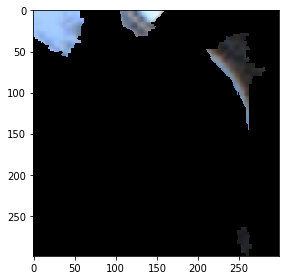

In [29]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

In [30]:
# Percentile implementation
# coeff.sort()
print(coeff)
# p = np.percentile(coeff, 50)
print("\npercentile is: ", np.percentile(coeff, 90))
percentile_rank = 90 / 100 * (num_superpixels + 1)  # calculates what rank is at 95th percentile: Rank = Percentile / 100 *(number of items + 1)
print(percentile_rank)
num_top_features = num_superpixels-round(percentile_rank)
print(num_top_features)
top_features = np.argsort(coeff)[-num_top_features:]
top_features

[ 0.01212899 -0.00791818 -0.00471299  0.01105576  0.00074436  0.01145329
 -0.00237696 -0.00198618 -0.00769894 -0.0034354  -0.0056285  -0.0132112
 -0.00598315  0.01020337  0.00591    -0.00102611  0.01097842 -0.00806492
 -0.01019001  0.00639791 -0.01238238  0.00836524 -0.00042846  0.00606436
  0.0019837   0.0002346   0.00531534 -0.00799563 -0.00128604  0.006448
 -0.00099913 -0.01217151 -0.00040247 -0.00529728  0.00752426 -0.00920572
  0.00680674  0.00384043  0.00287372  0.00968625 -0.00927673 -0.01294996
 -0.01088068 -0.00292288 -0.00412314  0.00130141 -0.00500748 -0.005183
  0.0100027  -0.00393024 -0.00023927 -0.01618541 -0.00535708 -0.00355679
  0.00841836  0.0024061   0.0051768   0.00806788  0.0082939  -0.00694594
 -0.0046818  -0.00622427  0.01007814  0.00166559  0.0047571   0.00360319
 -0.01340505]

percentile is:  0.009812830096574608
61.2
6


array([62, 13, 16,  3,  5,  0])

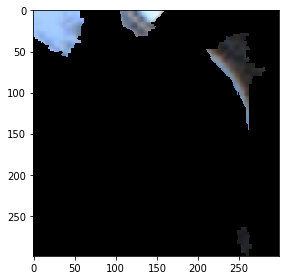

In [31]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))